# Deep Convolutional Generative Adversarial Network Example

Build a deep convolutional generative adversarial network (DCGAN) to generate digit images from a noise distribution with TensorFlow v2.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## DCGAN Overview

<img src="https://camo.githubusercontent.com/45e147fc9dfcf6a8e5df2c9b985078258b9974e3/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313030302f312a33394e6e6e695f6e685044614c7539416e544c6f57772e706e67" alt="dcgan" style="width: 1000px;"/>

References:
- [Unsupervised representation learning with deep convolutional generative adversarial networks](https://arxiv.org/pdf/1511.06434). A Radford, L Metz, S Chintala, 2016.
- [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a.html). X Glorot, Y Bengio. Aistats 9, 249-256
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). Sergey Ioffe, Christian Szegedy. 2015.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255. 

In this example, each image will be converted to float32 and normalized from [0, 255] to [0, 1].

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [11]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

In [12]:
# MNIST Dataset parameters.
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 20000
batch_size = 128
display_step = 500

# Network parameters.
noise_dim = 100 # Noise data points.

In [13]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [14]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [15]:
# Create TF Model.
class Generator(Model):
    # Set layers.
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = layers.Dense(7 * 7 * 128)
        self.bn1 = layers.BatchNormalization()
        self.conv2tr1 = layers.Conv2DTranspose(64, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.conv2tr2 = layers.Conv2DTranspose(1, 5, strides=2, padding='SAME')

    # Set forward pass.
    def call(self, x, is_training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Reshape to a 4-D array of images: (batch, height, width, channels)
        # New shape: (batch, 7, 7, 128)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        # Deconvolution, image shape: (batch, 14, 14, 64)
        x = self.conv2tr1(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        # Deconvolution, image shape: (batch, 28, 28, 1)
        x = self.conv2tr2(x)
        x = tf.nn.tanh(x)
        return x

# Generator Network
# Input: Noise, Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
class Discriminator(Model):
    # Set layers.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = layers.Conv2D(64, 5, strides=2, padding='SAME')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(128, 5, strides=2, padding='SAME')
        self.bn2 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024)
        self.bn3 = layers.BatchNormalization()
        self.fc2 = layers.Dense(2)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.bn1(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x, training=is_training)
        x = tf.nn.leaky_relu(x)
        return self.fc2(x)

# Build neural network model.
generator = Generator()
discriminator = Discriminator()

In [16]:
# Losses.
def generator_loss(reconstructed_image):
    gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=reconstructed_image, labels=tf.ones([batch_size], dtype=tf.int32)))
    return gen_loss

def discriminator_loss(disc_fake, disc_real):
    disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
    return disc_loss_real + disc_loss_fake

# Optimizers.
optimizer_gen = tf.optimizers.Adam(learning_rate=lr_generator)#, beta_1=0.5, beta_2=0.999)
optimizer_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)#, beta_1=0.5, beta_2=0.999)

In [17]:
# Optimization process. Inputs: real image and noise.
def run_optimization(real_images):
    
    # Rescale to [-1, 1], the input range of the discriminator
    real_images = real_images * 2. - 1.

    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)
        disc_real = discriminator(real_images, is_training=True)

        disc_loss = discriminator_loss(disc_fake, disc_real)
            
    # Training Variables for each optimizer
    gradients_disc = g.gradient(disc_loss,  discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients_disc,  discriminator.trainable_variables))
    
    # Generate noise.
    noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
    
    with tf.GradientTape() as g:
            
        fake_images = generator(noise, is_training=True)
        disc_fake = discriminator(fake_images, is_training=True)

        gen_loss = generator_loss(disc_fake)
            
    gradients_gen = g.gradient(gen_loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [18]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    
    if step == 0:
        # Generate noise.
        noise = np.random.normal(-1., 1., size=[batch_size, noise_dim]).astype(np.float32)
        gen_loss = generator_loss(discriminator(generator(noise)))
        disc_loss = discriminator_loss(discriminator(batch_x), discriminator(generator(noise)))
        print("initial: gen_loss: %f, disc_loss: %f" % (gen_loss, disc_loss))
        continue
    
    # Run the optimization.
    gen_loss, disc_loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print("step: %i, gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))

initial: gen_loss: 0.694535, disc_loss: 1.403878
step: 500, gen_loss: 2.154825, disc_loss: 0.429040
step: 1000, gen_loss: 2.103464, disc_loss: 0.502638
step: 1500, gen_loss: 2.282369, disc_loss: 0.572065
step: 2000, gen_loss: 2.711531, disc_loss: 0.341791
step: 2500, gen_loss: 2.835576, disc_loss: 0.322356
step: 3000, gen_loss: 2.970127, disc_loss: 0.275483
step: 3500, gen_loss: 2.836321, disc_loss: 0.190680
step: 4000, gen_loss: 2.892855, disc_loss: 0.337681
step: 4500, gen_loss: 2.948962, disc_loss: 0.329322
step: 5000, gen_loss: 3.799061, disc_loss: 0.327288
step: 5500, gen_loss: 4.090328, disc_loss: 0.274685
step: 6000, gen_loss: 4.343777, disc_loss: 0.155223
step: 6500, gen_loss: 3.806556, disc_loss: 0.155855
step: 7000, gen_loss: 4.827947, disc_loss: 0.078372
step: 7500, gen_loss: 3.708949, disc_loss: 0.140979
step: 8000, gen_loss: 5.250406, disc_loss: 0.164736
step: 8500, gen_loss: 5.491106, disc_loss: 0.110080
step: 9000, gen_loss: 4.391072, disc_loss: 0.100240
step: 9500, gen_

In [19]:
# Visualize predictions.
import matplotlib.pyplot as plt

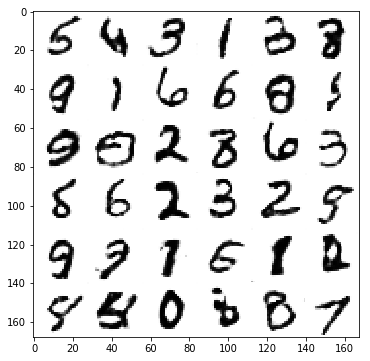

In [20]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.normal(-1., 1., size=[n, noise_dim]).astype(np.float32)
    # Generate image from noise.
    g = generator(z).numpy()
    # Rescale to original [0, 1]
    g = (g + 1.) / 2
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()